# Quantum Circuits
Quantum computers can only use a specific set of gates (universal gate set). Given the entanglers and their amplitudes found in Step 3, one can find corresponding representation of these operators in terms of elementary gates using the following procedure.

In [45]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

import tequila as tq
from utility import *
from qiskit import IBMQ
import openfermion

First, we set up the Hamiltonian in Tequila's format and the unitary gates obtained in Step 3. 

In [46]:
H = tq.QubitHamiltonian.from_openfermion(get_qubit_hamiltonian(['h2'], 2, 'sto-3g', qubit_transf='jw'))
print(H)

-0.5339+0.0673Z(0)+0.0673Z(1)+0.0067Z(2)+0.0067Z(3)+0.1274Z(0)Z(1)+0.0648Y(0)X(1)X(2)Y(3)-0.0648Y(0)Y(1)X(2)X(3)-0.0648X(0)X(1)Y(2)Y(3)+0.0648X(0)Y(1)Y(2)X(3)+0.0650Z(0)Z(2)+0.1298Z(0)Z(3)+0.1298Z(1)Z(2)+0.0650Z(1)Z(3)+0.1337Z(2)Z(3)


In [47]:
a = tq.Variable("tau_0")
U = construct_QMF_ansatz(4)
U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string("X(0)Y(1)X(2)X(3)"), angle=a)
print(U)

circuit: 
Rx(target=(0,), parameter=beta_0)
Rz(target=(0,), parameter=gamma_0)
Rx(target=(1,), parameter=beta_1)
Rz(target=(1,), parameter=gamma_1)
Rx(target=(2,), parameter=beta_2)
Rz(target=(2,), parameter=gamma_2)
Rx(target=(3,), parameter=beta_3)
Rz(target=(3,), parameter=gamma_3)
Exp-Pauli(target=(0, 1, 2, 3), control=(), parameter=tau_0, paulistring=X(0)Y(1)X(2)X(3))



In [48]:
circ = tq.circuit.compiler.compile_exponential_pauli_gate(U)
tq.draw(circ, backend="qiskit")

┌────────────────────┐┌─────────────────────┐┌──────────┐               »
q_0: ┤ Rx(f((beta_0,))_0) ├┤ Rz(f((gamma_0,))_1) ├┤ Ry(-π/2) ├──■────────────»
     ├────────────────────┤├─────────────────────┤├─────────┬┘┌─┴─┐          »
q_1: ┤ Rx(f((beta_1,))_2) ├┤ Rz(f((gamma_1,))_3) ├┤ Rx(π/2) ├─┤ X ├──■───────»
     ├────────────────────┤├─────────────────────┤├─────────┴┐└───┘┌─┴─┐     »
q_2: ┤ Rx(f((beta_2,))_4) ├┤ Rz(f((gamma_2,))_5) ├┤ Ry(-π/2) ├─────┤ X ├──■──»
     ├────────────────────┤├─────────────────────┤├──────────┤     └───┘┌─┴─┐»
q_3: ┤ Rx(f((beta_3,))_6) ├┤ Rz(f((gamma_3,))_7) ├┤ Ry(-π/2) ├──────────┤ X ├»
     └────────────────────┘└─────────────────────┘└──────────┘          └───┘»
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                     ┌─────────┐ 
«q_0: ──────────────────────────────────────────■─────┤ Ry(π/2) ├─
«                                             ┌─┴─┐   ├─────────┴┐
«q_1: ───────────────────────────────■────────┤ X ├───┤ Rx(-π/2) ├
«                                  ┌─┴─┐   ┌──┴───┴──┐└──────────┘
«q_2: ───────────────────────■─────┤ X ├───┤ Ry(π/2) ├────────────
«     ┌───────────────────┐┌─┴─┐┌──┴───┴──┐└─────────┘            
«q_3: ┤ Rz(f((tau_0,))_8) ├┤ X ├┤ Ry(π/2) ├───────────────────────
«     └───────────────────┘└───┘└─────────┘                       
«c: 4/════════════════════════════════════════════════════════════
«

In [39]:
optim_param = {'beta_1': 3.141592624143881, 'beta_0': 3.141592624143881, 'tau_0': 1.1331410014096885, 'gamma_1': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'gamma_2': 0.0, 'gamma_0': 0.0, 'beta_2': 0.0} # values obtained from step 3

In [40]:
optim_param['beta_0']

3.141592624143881

In [77]:
# Create circuit
circ_qiskit = QuantumCircuit(4)
for g in list(circ.gates):
    qbit = g.qubits
    if len(qbit) == 1:
        if str(type(g.parameter)) == "<class 'tequila.objective.objective.FixedVariable'>":
            param = g.parameter
        else:
            param = optim_param[g.parameter]

        if g.axis == 0:
            circ_qiskit.rx(param,qbit[0])
        elif g.axis == 1:
            circ_qiskit.ry(param,qbit[0])
        elif g.axis == 2:
            circ_qiskit.rz(param,qbit[0]) 
    elif  len(qbit) == 2:
        circ_qiskit.cx(qbit[0],qbit[1])

KeyError: f([tau_0])

In [81]:
g.parameter.args

(tau_0,)

One can check the expectation value to see it is near the ground state energy.

In [7]:
E = tq.ExpectationValue(H=H, U=U)
print(tq.simulate(E, variables=optim_param))

-0.9486411121761622


One can run the same experiment on a real quantum computer through IBM Quantum Experience (ibmq). After activating your account here (https://quantum-computing.ibm.com/login), copy the API token and execute the commented block below. 

In [8]:
# IBMQ.save_account('#MYTOKEN')

In [9]:
from IPython.display import clear_output
token = input()
clear_output()

In [10]:
provider = IBMQ.enable_account(token)

In [11]:
for backend in provider.backends():
    print(backend.status().to_dict())

{'backend_name': 'ibmq_armonk', 'backend_version': '2.4.13', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active'}
{'backend_name': 'simulator_mps', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 2, 'status_msg': 'active'}
{'backend_name': 'ibmq_belem', 'backend_version': '1.0.15', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active'}
{'backend_name': 'ibmq_qasm_simulator', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 2, 'status_msg': 'active'}
{'backend_name': 'ibmq_santiago', 'backend_version': '1.3.26', 'operational': True, 'pending_jobs': 50, 'status_msg': 'active'}
{'backend_name': 'simulator_statevector', 'backend_version': '0.1.547', 'operational': True, 'pending_jobs': 2, 'status_msg': 'active'}
{'backend_name': 'ibmq_bogota', 'backend_version': '1.4.38', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active'}
{'backend_name': 'ibmq_lima', 'backend_version': '1.0.14', 'operational': True, 'pending_jobs': 0, '

In [17]:
# list of devices available can be found in ibmq account page
# Try a device that isn't too busy. If the wait time is too long, measure only one pauli-word in the H2 Hamilotonian using the commented line
# E = tq.ExpectationValue(H=tq.QubitHamiltonian.from_paulistrings("X(0)X(1)Y(2)Y(3)"), U=U)
tq.simulate(E, variables=vars, samples=100, backend="qiskit", device='ibmq_belem')

-0.6743664041121934

define the number operator for H2

In [ ]:
# N=tq.QubitHamiltonian.from_string("2-0.5Z(0)+0.5Z(1)Z(0)+0.5Z(2)")

In [18]:
hamf = openfermion.hamiltonians.number_operator(4)

In [19]:
# ham = mol.get_molecular_hamiltonian()
# hamf = get_fermion_operator(ham)

# qubit_transf = 'bk'
qubit_transf = 'jw'

if qubit_transf == 'bk':
    hamq = bravyi_kitaev(hamf)
elif qubit_transf == 'jw':
    hamq = jordan_wigner(hamf)
else:
    raise(ValueError(qubit_transf, 'Unknown transformation specified'))

hamq = remove_complex(hamq)

In [23]:
print(hamq)

2.0 [] +
-0.5 [Z0] +
-0.5 [Z1] +
-0.5 [Z2] +
-0.5 [Z3]


In [20]:
N = tq.QubitHamiltonian.from_openfermion(hamq)

In [21]:
E = tq.ExpectationValue(H=N, U=U)
outs = tq.simulate(E, variables=optim_param)

In [22]:
outs

1.9999999999999982

In [ ]:
H = hamq

In [24]:
print(H)

-0.5339+0.0673Z(0)+0.0673Z(1)+0.0067Z(2)+0.0067Z(3)+0.1274Z(0)Z(1)+0.0648Y(0)X(1)X(2)Y(3)-0.0648Y(0)Y(1)X(2)X(3)-0.0648X(0)X(1)Y(2)Y(3)+0.0648X(0)Y(1)Y(2)X(3)+0.0650Z(0)Z(2)+0.1298Z(0)Z(3)+0.1298Z(1)Z(2)+0.0650Z(1)Z(3)+0.1337Z(2)Z(3)


In [26]:
H = get_qubit_hamiltonian(['h2'], 2, 'sto-3g', qubit_transf='jw')

In [29]:
h = H.get_operators()

In [33]:
H.terms

{(): -0.5339363487727402,
 ((0, 'Z'),): 0.06727930458983412,
 ((1, 'Z'),): 0.0672793045898341,
 ((2, 'Z'),): 0.006651295687574416,
 ((3, 'Z'),): 0.006651295687574388,
 ((0, 'Z'), (1, 'Z')): 0.12736570310657463,
 ((0, 'Y'), (1, 'X'), (2, 'X'), (3, 'Y')): 0.06478461872026421,
 ((0, 'Y'), (1, 'Y'), (2, 'X'), (3, 'X')): -0.06478461872026421,
 ((0, 'X'), (1, 'X'), (2, 'Y'), (3, 'Y')): -0.06478461872026421,
 ((0, 'X'), (1, 'Y'), (2, 'Y'), (3, 'X')): 0.06478461872026421,
 ((0, 'Z'), (2, 'Z')): 0.06501569581211995,
 ((0, 'Z'), (3, 'Z')): 0.12980031453238416,
 ((1, 'Z'), (2, 'Z')): 0.12980031453238416,
 ((1, 'Z'), (3, 'Z')): 0.06501569581211995,
 ((2, 'Z'), (3, 'Z')): 0.13366602988233997}

In [ ]:
tq.

In [24]:
from qiskit import QuantumCircuit, Aer
from qiskit.aqua.operators import PauliExpectation, CircuitSampler
from qiskit.aqua import QuantumInstance

In [25]:
psi = QuantumCircuit(2)
psi.x(0) 
psi.x(1)


In [26]:
backend = Aer.get_backend('qasm_simulator') 
q_instance = QuantumInstance(backend, shots=1024)

In [27]:
sampler = CircuitSampler(q_instance)

In [28]:
sampler

In [6]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

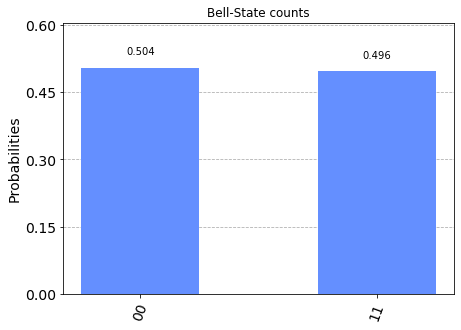

In [7]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [8]:
# Create circuit
circ = QuantumCircuit(4)
circ.rx(np.pi,0)
circ.rz(np.pi,0)

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

QiskitError: 'No counts for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fe2747f28d0>"'

In [9]:
circ.draw()

┌───────┐
q_0: ┤ Rx(π) ├
     └───────┘
q_1: ─────────
              
q_2: ─────────
              
q_3: ─────────

In [ ]:
'beta_1': 3.141592624143881, 'beta_0': 3.141592624143881, 'tau_0': 1.1331410014096885, 'gamma_1': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'gamma_2': 0.0, 'gamma_0': 0.0, 'beta_2': 0.0